In [347]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import newton
from scipy.interpolate import interp1d
from scipy.integrate import solve_bvp, solve_ivp

plt.style.use('bmh')

In [2]:
rho_max = 0.2
rho_cr = 0.0278
V_cr = 20
V_max = 40
W_max = 5
Q_max = 0.556

alpha = (Q_max/(rho_max - rho_cr)**2) - (W_max/(rho_max - rho_cr))


def Q_e(rho):
        
    val_1 = lambda rho: rho*(V_max - rho/rho_cr * (V_max - V_cr))
    val_2 = lambda rho: W_max*(rho_max - rho) + alpha*(rho_max - rho)**2
    
    output = np.piecewise(rho, [(0 <= rho) & (rho < rho_cr), (rho_cr <= rho) & (rho<= rho_max)], [val_1, val_2])
    return output

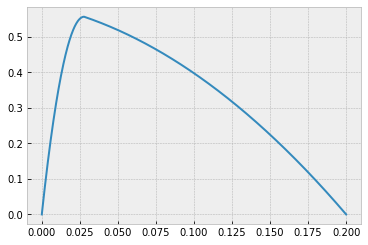

In [3]:
rho = np.linspace(0, rho_max, 1000)
plt.plot(rho, Q_e(rho))

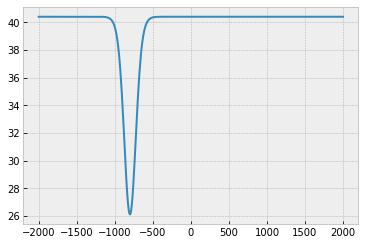

In [4]:

x = np.linspace(-2000, 2000, 4000//10)
Q_0 = lambda x: np.exp(-((x+800)**2)/20_000)/2+0.1
u_0 = lambda x: 1/(np.exp(-((x+800)**2)/20_000)/2+0.1)

plt.plot(x, 40.8*(1-Q_0(x)**(2)))

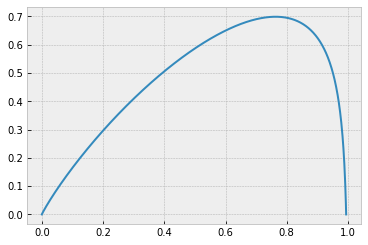

In [5]:
rho_max = 1/7.5
u_max = 20
beta = 12
gamma_1 = 1/5
gamma_2 = 1/10

h = lambda rho: beta * ((rho/rho_max)**gamma_1/((1-(rho/rho_max))**gamma_2))

U = lambda rho: u_max - h(rho)

def Q(rho): 
    
    if np.isclose(rho, rho_max):
        return 0
    
    output = rho * U(rho)
    return output

zero = np.real(newton(U,rho_max-1e-4))
rhos = np.linspace(0, zero, 1_000)
Q_to_plot = [Q(rho) for rho in rhos]
plt.plot(rhos/rho_max, Q_to_plot)
plt.show()

In [6]:
def Q_prime(rho):
    rho_bar = rho/rho_max
    output_1 = U(rho)
    output_2 = (gamma_1 * rho_bar**gamma_1)/((1-rho_bar)**gamma_2)
    output_3 = (gamma_2 * rho_bar**gamma_1)/(rho * rho_max * ((1-rho_bar)**(gamma_2+1)))
    output_4 = beta * (output_2 + output_3)
    output = output_1 + output_4
    return output

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


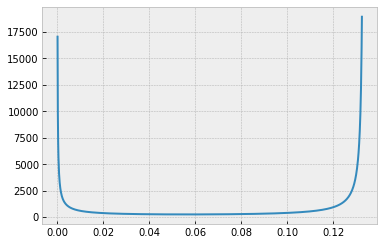

In [7]:
Q_p_to_plot = [Q_prime(rho) for rho in rhos]
plt.plot(rhos, Q_p_to_plot)
plt.show()

In [8]:
Q_p_inv = lambda x: Q_prime(x)-600
newton(Q_p_inv, 0.01)

0.009960575449567735

In [9]:
Q_prime(zero)

18946.947188802646

#####################################

In [10]:
gamma = 1/2
beta = 8
u_max = 20
rho_max = 1/7.5

def h_(rho):
    output = beta * (rho /(rho_max - rho))**gamma
    return output

def U_(rho):
    return u_max - h_(rho)

def Q_(rho):
    if np.isclose(rho, rho_max):
        return 0.0
    
    output = rho * U_(rho)
    return output

def U_prime_(rho):
    output = gamma * rho_max * h_(rho) * (rho/(rho_max - rho))
    return output

def U_inv_(z):
    output = rho_max * (((u_max-z)/beta)**(1/gamma)/(1 + ((u_max-z)/beta)**(1/gamma)))
    return output

def Q_prime_(rho):
    output = U_(rho) + gamma * rho_max * h_(rho) * (rho**2)/(rho_max - rho)
    return output

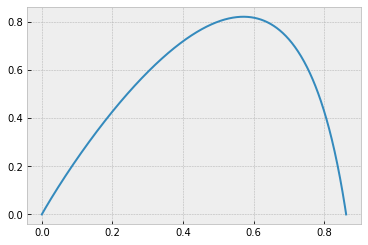

In [11]:
zero = np.real(newton(U_,rho_max-1e-4))
rhos = np.linspace(0, zero, 1_000)
Q_to_plot = [Q_(rho) for rho in rhos]
plt.plot(rhos/rho_max, Q_to_plot)
plt.show()

In [12]:
Q_prime(zero)

460.29475471328453

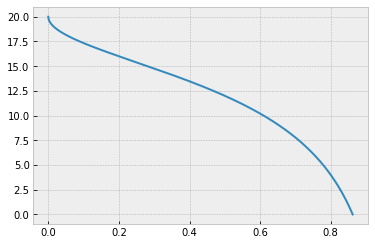

In [13]:
plt.plot(rhos/rho_max, U_(rhos))
plt.show()

In [14]:
plt.plot(rhos/rho_max, U_prime_(rhos))
plt.show()

In [15]:
zs = np.linspace(0, 20, 1000)
plt.plot(zs, U_inv_(zs))
plt.show()

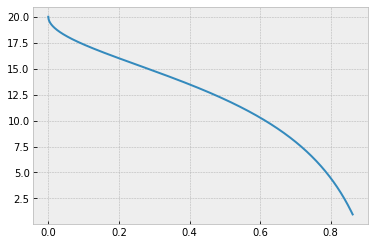

In [16]:
plt.plot(rhos/rho_max, Q_prime_(rhos))
plt.show()

In [17]:
def Q_p_inv_points_(z):
    z = float(z)
    Q_to_inv = lambda x: Q_prime_(x)-z
    
    if 19.7 < z <= u_max:
        rho = np.real(newton(Q_to_inv, 0.0))
        return rho
    
    rho = np.real(newton(Q_to_inv, 0.8*rho_max))
    return rho

In [18]:
zs = np.linspace(0.96, u_max, 50)
Q_p_inv_to_poly = [Q_p_inv_points_(z) for z in zs]

Q_inv_ = interp1d(zs, Q_p_inv_to_poly)


In [19]:
z_to_plot = np.linspace(1., 20, 100)
plt.plot(z_to_plot, Q_inv_(z_to_plot))
plt.show()

In [20]:
def Q_0_3(x, U):
    
    # Gaussiana centrada en 1500
    rho_0 = (np.exp(-((x-400)**2)/20_000)/6+0.3)*rho_max #np.exp(-x**2/(2*2.7**2))/(2.7*np.sqrt(2*np.pi))
    
    # Menor velocidad en mayor densidad
    u_0 = 1/rho_0
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con codicion
    Q_0_ = np.zeros([2, len(x)])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_


In [21]:
x = np.linspace(0, 1000, 1000)
plt.plot(x, Q_0_3(x, U_)[1])

###################################

In [22]:
gamma = 1/2
beta = 8
u_max = 20
rho_max = 1/7.5
c = 0.078 * u_max * rho_max
b = 1/3
l = 1/10
tau = 5

def h(rho):
    output = beta * (rho /(rho_max - rho))**gamma
    return output

def h_prime(rho):
    output =  beta * gamma * (rho /(rho_max - rho))**(gamma-1) * rho_max / ((rho_max - rho)**2)
    return output

def g(y):
    output = np.sqrt(1 + ((y-b)/l)**2 )
    return output

def Q(rho):
    output = c * (g(0) + (((g(1) - g(0))* rho/rho_max)) - g(rho/rho_max))
    return output

def g_prime(y):
    output = (1/l**2) * ((y-b)/ np.sqrt(1 + ((y-b)/l)**2)) 
    return output

def Q_prime(rho):
    output = c * ( ((g(1) - g(0))/rho_max) - (g_prime(rho/rho_max)/rho_max))
    return output

def U(rho):
    return Q(rho)/rho

def U_prime(rho):
    output = (Q_prime(rho)*rho - Q(rho))/(rho**2)
    return output


# Inversa de U
def U_inv_points(z):
    z = float(z)
    U_to_inv = lambda x: U(x)-z
    
    rho = np.real(newton(U_to_inv, 0.5*rho_max))
    return rho

zs_U = np.linspace(u_max, 0, 50)
U_inv_to_poly = [U_inv_points(z) for z in zs_U]

U_inv = interp1d(zs_U, U_inv_to_poly)


# Inversa de la derivada de Q
def Q_p_inv_points(z):
    z = float(z)
    Q_to_inv = lambda x: Q_prime(x)-z
    
    rho = np.real(newton(Q_to_inv, 0.3*rho_max))
    return rho

zs_Q = np.linspace(Q_prime(rhos).min(), u_max, 50)
Q_p_inv_to_poly = [Q_p_inv_points(z) for z in zs_Q]

Q_p_inv = interp1d(zs_Q, Q_p_inv_to_poly)

In [23]:
rhos = np.linspace(0, rho_max-1e-5, 100_000)
plt.plot(rhos/rho_max, h(rhos))
plt.xlim(-0.05, 1)
plt.ylim(-10, 50)
plt.show()

In [24]:
plt.plot(rhos/rho_max, h_prime(rhos))
plt.xlim(-0.05, 1)
plt.ylim(0, 500)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


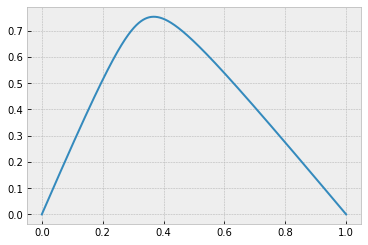

In [25]:
plt.plot(rhos/rho_max, Q(rhos))
plt.show()

In [26]:
plt.plot(rhos/rho_max, U(rhos))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [27]:
plt.plot(rhos/rho_max, Q_prime(rhos))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


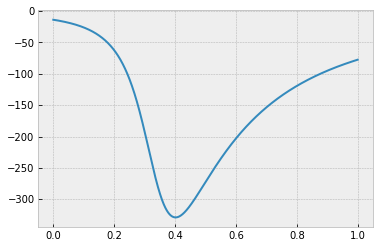

In [28]:
plt.plot(rhos/rho_max, U_prime(rhos))
plt.show()

In [29]:
plt.plot(rhos/rho_max, U_prime(rhos) + h_prime(rhos))
plt.xlim(-0.05, 1)
plt.ylim(-300, 200)
plt.hlines(0, -0.05, 1, ls="--")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


In [30]:
def U_inv_points(z):
    z = float(z)
    U_to_inv = lambda x: U(x)-z
    
    rho = np.real(newton(U_to_inv, 0.5*rho_max))
    return rho

zs = np.linspace(u_max, 0, 50)
U_inv_to_poly = [U_inv_points(z) for z in zs]

U_inv = interp1d(zs, U_inv_to_poly)

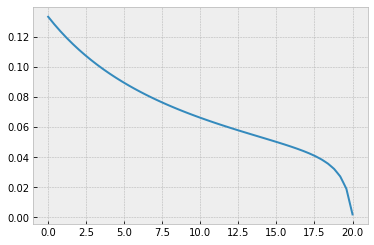

In [31]:
z_to_plot = np.linspace(u_max, 0, 100)
plt.plot(z_to_plot, U_inv(z_to_plot))
plt.show()

In [32]:
def Q_p_inv_points(z):
    z = float(z)
    Q_to_inv = lambda x: Q_prime(x)-z
    
    rho = np.real(newton(Q_to_inv, 0.3*rho_max))
    return rho


zs = np.linspace(Q_prime(rhos).min(), u_max, 50)
Q_p_inv_to_poly = [Q_p_inv_points(z) for z in zs]

Q_p_inv = interp1d(zs, Q_p_inv_to_poly)

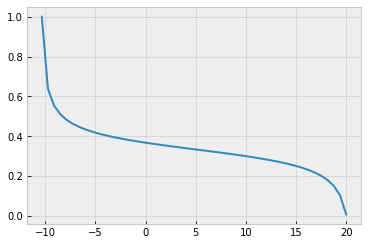

In [33]:
z_to_plot = np.linspace(Q_prime(rhos).min(), 20, 100)
plt.plot(z_to_plot, Q_p_inv(z_to_plot)/rho_max)
plt.show()

## Construcción de jamitones

In [264]:
rho_s = 0.37 * rho_max # Está normalizado

m = rho_s**2 * h_prime(rho_s)
s = U(rho_s) - rho_s*h_prime(rho_s)

rho_plus, u_plus = 0.5*rho_max, 12

# Condiciones de rankine-hugoniot
def alpha_plus(rho_plus, u_plus):
    output = s * rho_plus - rho_plus * u_plus
    return output

def beta_plus(rho_plus, u_plus):
    output_1 = s * rho_plus * (u_plus + h(rho_plus))
    output_2 = -rho_plus * u_plus**2
    output_3 = -rho_plus * u_plus * h(rho_plus)
    return output_1 + output_2 + output_3

def gamma_plus(rho_plus, u_plus):
    output = beta_plus(rho_plus, u_plus)/alpha_plus(rho_plus, u_plus)
    return output

def find_rho_minus(rho_plus, u_plus):
    rho_fun = lambda rho: rho * (s - gamma_plus(rho_plus, u_plus) + h(rho)) - alpha_plus(rho_plus, u_plus)
    rho_minus = newton(rho_fun, 0)
    return rho_minus

def find_u_minus(rho_plus, u_plus, rho_minus):
    output = gamma_plus(rho_plus, u_plus) - h(rho_minus)
    return output

In [265]:
rho_minus = find_rho_minus(rho_plus, u_plus)
u_minus = find_u_minus(rho_plus, u_plus, rho_minus)
rho_minus/rho_max, u_minus

(0.1202138965365209, 17.04281308930704)

In [266]:
rho_fun = lambda rho: rho * (s - gamma_plus(rho_plus, u_plus) + h(rho)) - alpha_plus(rho_plus, u_plus)
plt.plot(rhos/rho_max, rho_fun(rhos))
plt.ylim(-0.25, 0.25)
plt.hlines(0, 0, 1, ls="--")

In [267]:
def jam_EDO(x, u):
    rho = m / (u - s)
    output_1 = (u - s) * (U(rho) - u)
    output_2 =  (u - s)**2 - m * h_prime(rho)
    return output_1/(output_2 * tau)

# Condicion de borde
def bc(ua, ub):
    return ua - ub - u_plus + u_minus

x_to_solve = np.linspace(0, 50, 1000)
u_to_solve = np.zeros((1, x_to_solve.size))

u_to_solve[-1] = u_minus

sol = solve_bvp(jam_EDO, bc, x_to_solve, u_to_solve)

In [268]:
u_sol = sol.y[0]
rho_sol = m/(u_sol - s)

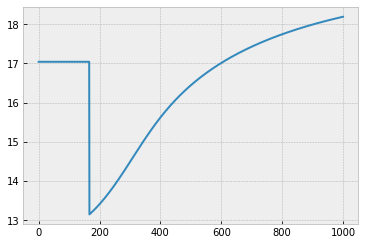

In [269]:
u_cte = np.ones(200)*u_minus
u_final = np.append(u_cte, u_sol)
x_final = np.linspace(0, 1000, 1200)
plt.plot(x_final, u_final)

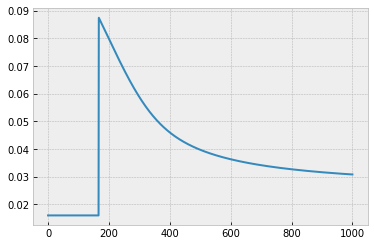

In [270]:
rho_cte = np.ones(200)*rho_minus
rho_final = np.append(rho_cte, rho_sol)
plt.plot(x_final, rho_final)

## Variables lagrangeanas

In [342]:
v_s = 1/rho_s # Se necesita rho_s normalizado

def h_bar(v):
    return h(1/v)

def h_bar_prime(v):
    output = -h_prime(1/v)/v**2 
    return output

def U_bar(v):
    return U(1/v)

m_bar = -h_bar_prime(v_s)
s_bar = U_bar(v_s) - m_bar * v_s

def w(v):
    output = U_bar(v) - (m_bar * v + s_bar)
    return output

def r(v):
    output = m_bar * h_bar(v) + m_bar**2 * v
    return output

def r_prime(v):
    output = m_bar * h_bar_prime(v) + m_bar**2
    return output

def ode_jam_v(chi, v):
    output = w(v)/(r_prime(v) * v)
    return output

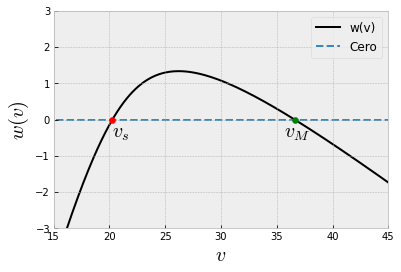

In [340]:
v_to_plot = np.linspace(10, 100, 1000)#15, 50, 1000)#
plt.plot(v_to_plot, w(v_to_plot), label="w(v)", zorder=0, color="black")
#plt.xlim(20, 37.5)
#plt.ylim(-1, 0.5)

plt.xlim(15, 45)
plt.ylim(-3, 3)

plt.hlines(0, 1, 55, ls="--", label="Cero", zorder=1)
plt.scatter(v_s, w(v_s), color="red", zorder=2)
plt.annotate(r"$v_s$", (v_s, w(v_s)-0.5), fontsize=20)

# jamiton maximal
v_M = newton(w, 40)
plt.scatter(v_M, w(v_M), color="green", zorder=2)
plt.annotate(r"$v_M$", (v_M-1, w(v_M)-0.5), fontsize=20)

plt.xlabel(r"$v$", fontsize=20)
plt.ylabel(r"$w(v)$", fontsize=20)
plt.legend(fontsize=12)
# Existe jamiton pues w'(vs)>0
plt.show()

In [326]:
plt.plot(v_to_plot, r(v_to_plot), zorder=0, color="black", label="r(v)")

plt.xlim(10, 40)
plt.ylim(2.5, 3.5)

r_min = r(v_s)
r_max = r(v_M)

# Velocidad sonica
plt.scatter(v_s, r_min, color="red", zorder=2)
plt.annotate(r"$v_s$", (v_s, r_min-0.08), fontsize=20)

# jamiton maximal
plt.scatter(v_M, r_max, color="green", zorder=2)
plt.annotate(r"$v_M$", (v_M, r_max-0.08), fontsize=20)

v_R = newton(lambda v: r(v) - r_max, 15)
plt.scatter(v_R, r(v_R), color="green", zorder=2)
plt.annotate(r"$v_R$", (v_R-1.5, r(v_R)-0.08), fontsize=20)

# Linea de jamiton maximal
plt.hlines(r_max, v_R, v_M, color="blue", ls="--", label="jamiton maximal", zorder=1)

# Jamiton actual
v_minus = 31
r_minus = r(v_minus)
v_plus = newton(lambda v: r(v) - r_minus, 15)
r_plus = r(v_plus)

plt.scatter(v_minus, r_minus, color="purple", zorder=2)
plt.annotate(r"$v_-$", (v_minus, r_minus-0.08), fontsize=20)

plt.scatter(v_plus, r_plus, color="purple", zorder=2)
plt.annotate(r"$v_+$", (v_plus-1.5, r_plus-0.08), fontsize=20)

# Linea de jamiton actual
plt.hlines(r_minus, v_plus, v_minus, color="brown", ls="--", label="jamiton actual", zorder=1)

plt.xlabel(r"$v$", fontsize=20)
plt.ylabel(r"$r(v)$", fontsize=20)
plt.legend(fontsize=12)
plt.show()

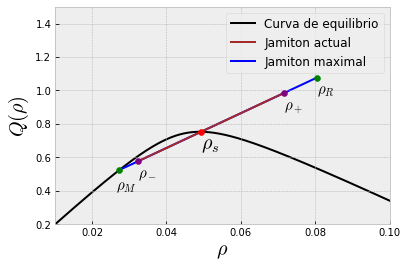

In [341]:
# Diagrama fundamental
plt.plot(rhos, Q(rhos), zorder=0, color="black", label="Curva de equilibrio")
plt.xlim(0.01, 0.1)
plt.ylim(0.2, 1.5)

rho_plus = (1/v_plus)
rho_minus = (1/v_minus)
rho_M = (1/v_M)
rho_R = (1/v_R)

rho_s = 1/v_s

plt.scatter(rho_s, Q(rho_s), color="red", zorder=3)
plt.annotate(r"$\rho_s$", (rho_s, Q(rho_s)-0.1), fontsize=20)

plt.scatter(rho_plus, m_bar + s_bar * rho_plus, color="purple", zorder=3)
plt.annotate(r"$\rho_+$", (rho_plus, (m_bar + s_bar * rho_plus)-0.1), fontsize=15)
plt.scatter(rho_minus, m_bar + s_bar * rho_minus, color="purple", zorder=3)
plt.annotate(r"$\rho_-$", (rho_minus, (m_bar + s_bar * rho_minus)-0.1), fontsize=15)

plt.scatter(rho_M, m_bar + s_bar * rho_M, color="green", zorder=3)
plt.annotate(r"$\rho_M$", (rho_M-0.001, (m_bar + s_bar * rho_M)-0.12), fontsize=15)
plt.scatter(rho_R,  m_bar + s_bar * rho_R, color="green", zorder=3)
plt.annotate(r"$\rho_R$", (rho_R,  (m_bar + s_bar * rho_R)-0.1), fontsize=15)

plt.plot([rho_plus, rho_minus], [m_bar + s_bar * rho_plus, m_bar + s_bar * rho_minus], color="brown", ls="-", 
         zorder=2, label="Jamiton actual")
plt.plot([rho_M, rho_R], [m_bar + s_bar * rho_M, m_bar + s_bar * rho_R], color="blue", ls="-", 
         zorder=1, label="Jamiton maximal")

plt.ylabel(r"$Q(\rho)$", fontsize=20)
plt.xlabel(r"$\rho$", fontsize=20)
plt.legend(fontsize=12)
plt.show()

In [430]:
# Condicion de borde
def bc_v(va, vb):
    return va - vb - v_plus + v_minus

eta_to_solve = np.linspace(100, 1000, 1000)
v_to_solve = np.zeros((1, eta_to_solve.size))
u_to_solve[-1] = v_minus

sol_v = solve_ivp(ode_jam_v, (0, 35), [v_R], t_eval=np.linspace(0, 35, 100), dense_output=True)

In [512]:
# Encuentra etas
eta_minus = newton(lambda v: sol_v.sol(v)[0] - v_minus, 0)
eta_plus = newton(lambda v: sol_v.sol(v)[0] - v_plus, 0)
eta_s = newton(lambda v: sol_v.sol(v)[0] - v_s, 0)
eta_to_plot = sol_v.t
eta_to_per = np.linspace(eta_minus, sol_v.t[-1], 500)

# Jamiton actual
eta_jam = np.linspace(eta_plus, eta_minus, 500)
v_jam = sol_v.sol(eta_jam)[0]

# Cadena de jamitones
def v_per(eta):
    interval = eta_plus - eta_minus
    return sol_v.sol((eta - eta_minus) % interval + eta_minus)[0]

plt.plot(eta_jam, v_jam, zorder=1, label="Jamiton actual", color="brown")
plt.plot(eta_to_per, v_per(eta_to_per), zorder=0, color="brown", ls="--", label="Cadena de jamitones")

plt.scatter(eta_plus, sol_v.sol(eta_plus)[0], zorder=2, color="green")
plt.annotate(r"$v_+$", (eta_plus+1, sol_v.sol(eta_plus)[0]-1), fontsize=20)
plt.scatter(eta_minus, sol_v.sol(eta_minus)[0], zorder=2, color="green")
plt.annotate(r"$v_-$", (eta_minus+1, sol_v.sol(eta_minus)[0]-1), fontsize=20)
plt.scatter(eta_s, v_s, zorder=2, color="red", label="Punto sónico")
plt.annotate(r"$v_s$", (eta_s+1, v_s-1), fontsize=20)


# Jamiton maximal
plt.plot(eta_to_plot, sol_v.y[0], zorder=0, label="Jamiton maximal")
plt.scatter(0, v_R, color="purple")
plt.annotate(r"$v_R$", (-3.5, v_R-1), fontsize=20)
plt.hlines(v_M, 0, 40, color="purple", zorder=0, ls="--")
plt.annotate(r"$v_M$", (v_M, 35), fontsize=20)

plt.xlim(-5, 42)
plt.ylim(10, 40)
plt.xlabel(r"$\eta$", fontsize=20)
plt.ylabel(r"$v(\eta)$", fontsize=20)
plt.legend(fontsize=12)
plt.show()

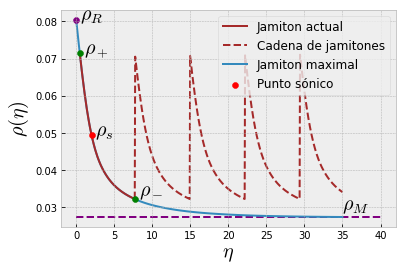

In [531]:
# Define densidad
sol_rho = lambda eta: 1/sol_v.sol(eta)[0]


# Jamiton actual
rho_jam = sol_rho(eta_jam)
rho_y = 1/sol_v.y[0]

# Cadena de jamitones
def rho_per(eta):
    interval = eta_plus - eta_minus
    return sol_rho((eta - eta_minus) % interval + eta_minus)

plt.plot(eta_jam, rho_jam, zorder=1, label="Jamiton actual", color="brown")
plt.plot(eta_to_per, rho_per(eta_to_per), zorder=0, color="brown", ls="--", label="Cadena de jamitones")

plt.scatter(eta_plus, sol_rho(eta_plus), zorder=2, color="green")
plt.annotate(r"$\rho_+$", (eta_plus+0.5, sol_rho(eta_plus)), fontsize=20)
plt.scatter(eta_minus, sol_rho(eta_minus), zorder=2, color="green")
plt.annotate(r"$\rho_-$", (eta_minus+0.5, sol_rho(eta_minus)+0.001), fontsize=20)
plt.scatter(eta_s, rho_s, zorder=2, color="red", label="Punto sónico")
plt.annotate(r"$\rho_s$", (eta_s+0.5, rho_s), fontsize=20)

# Jamiton maximal
plt.plot(eta_to_plot, rho_y, zorder=0, label="Jamiton maximal")
plt.scatter(0, rho_R, color="purple")
plt.annotate(r"$\rho_R$", (0.5, rho_R), fontsize=20)
plt.hlines(rho_M, 0, 40, color="purple", zorder=0, ls="--")
plt.annotate(r"$\rho_M$", (35, rho_M+0.002), fontsize=20)

plt.xlabel(r"$\eta$", fontsize=20)
plt.ylabel(r"$\rho(\eta)$", fontsize=20)
plt.legend(fontsize=12)
plt.show()

In [541]:
# Define velocidad
sol_u = lambda eta: (m_bar/sol_rho(eta)) + s_bar

# Jamiton actual
u_jam = sol_u(eta_jam)
u_y = (m_bar/rho_y) + s_bar
u_s = (m_bar/rho_s) + s_bar
u_R = (m_bar/rho_R) + s_bar
u_M = (m_bar/rho_M) + s_bar

# Cadena de jamitones
def u_per(eta):
    interval = eta_plus - eta_minus
    return sol_u((eta - eta_minus) % interval + eta_minus)

plt.plot(eta_jam, u_jam, zorder=1, label="Jamiton actual", color="brown")
plt.plot(eta_to_per, u_per(eta_to_per), zorder=0, color="brown", ls="--", label="Cadena de jamitones")

plt.scatter(eta_plus, sol_u(eta_plus), zorder=2, color="green")
plt.annotate(r"$u_+$", (eta_plus+0.5, sol_u(eta_plus)), fontsize=20)
plt.scatter(eta_minus, sol_u(eta_minus), zorder=2, color="green")
plt.annotate(r"$u_-$", (eta_minus+0.5, sol_u(eta_minus)+0.001), fontsize=20)
plt.scatter(eta_s, u_s, zorder=2, color="red", label="Punto sónico")
plt.annotate(r"$u_s$", (eta_s+0.5, u_s), fontsize=20)

# Jamiton maximal
plt.plot(eta_to_plot, u_y, zorder=0, label="Jamiton maximal")
plt.scatter(0, u_R, color="purple")
plt.annotate(r"$u_R$", (0.5, u_R-0.1), fontsize=20)
plt.hlines(u_M, 0, 40, color="purple", zorder=0, ls="--")
plt.annotate(r"$u_M$", (35, u_M-0.4), fontsize=20)

plt.xlabel(r"$\eta$", fontsize=20)
plt.ylabel(r"$u(\eta)$", fontsize=20)
plt.legend(fontsize=12)
plt.show()